## Multi-Armed Bandits

<center><img src="./img/bandit.jpg"/></center>

In this lab, we will delve into the exploration-exploitation dilemma represented by the multi-armed bandit problem. Imagine having several strategies or options at your disposal, each with an unknown return. How do you decide which option to pursue, knowing that exploring could yield better returns, but sticking to the known could be safer?

We will be navigating through a simulation where we have a set of `bandits`, each representing an option with a different, unknown reward probability. This setup is analogous to real-world scenarios where decisions are made under uncertainty.

In the real world, the multi-armed bandit framework is used in various fields. For instance:

- **Online Advertising:** Determining which ad to display to maximize click-through rates.
- **Clinical Trials:** Quickly identifying the most effective treatment by adaptively allocating patients to different treatments.
- **Recommendation Systems:** Adapting to user preferences in real-time to recommend relevant items.

The multi-armed bandit problem serves as an introduction into the world of Reinforcement Learning, an area of ML where agents learn to make decisions by performing actions and receiving feedback from their environment. Multi-armed bandits are a small part of the larger RL landscape, which focuses on the decision-making process: How do we learn the value of actions through trial and error?

In RL, agents face a similar challenge but in more complex environments. They not only have to choose between different actions but also consider the long-term consequences of those actions. The multi-armed bandit is like a single decision point in RL, without the complication of future decisions impacting the current one.

In this lab, we will explore various algorithms designed to strike a balance between exploration and exploitation. Let's dive in!

In [1]:
# !pip3 install seaborn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from dataclasses import dataclass, field


sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

## Choose the arm

In practical applications, numerous reward structures can be associated with each arm. For this lab, we'll concentrate on two primary structures:

- **Bernoulli bandit**: Rewards with a 1 at a probability of `p` and a 0 at a probability of `1 - p`.
- **Gaussian bandit**: Offers rewards that are normally distributed around a value `p`, with a consistent variance (we would assume that variance = 1 in all experiments in this lab)


In [3]:
def pull_np(i_array, means):
    """Pulls the arms, assuming that the underlying distribution of rewards is Bernoulli."""
    return np.array(np.random.rand(len(i_array)) < means[np.array(i_array)], dtype=int)


def pull_gauss_np(i_array, means, variance=1.0):
    """Pulls the arms, assuming that the underlying distribution of rewards is Normal."""
    return np.array([np.random.normal(means[i], variance) for i in i_array])

Now, let's implement the base class, `BaseBandit`, which we will use later to implement various bandit strategies. In our class, we will store a history of all interactions with the environment. Each entry will be represented by a `HistoryRecord`, describing the numeric reward received from the interaction and the ID of the arm that was pulled. We will also maintain counters for each arm (indicating how many times that particular arm was pulled) as well as the cumulative reward each arm has received.

In [4]:
@dataclass
class HistoryRecord:
    arm_idx: int
    reward: float


class BaseBandit:
    """
    Represents a basic bandit model that selects arms and tracks the history of selections and rewards.

    Attributes
    ----------
    num_arms : int
        The number of arms in the bandit.

    arms_counter : np.ndarray
        Array tracking the number of times each arm has been selected.

    rewards : np.ndarray
        Array tracking the cumulative rewards obtained from each arm.

    label : str
        A label for the bandit instance, defaults to the class name.

    hist : list[HistoryRecord]
        A list of history records detailing each arm selection and its resulting reward.
    """

    def __init__(self, num_arms: int, label: str = None):
        """
        Initialize a new instance of BaseBandit.

        Parameters
        ----------
        num_arms : int
            The number of arms in the bandit.

        label : str, optional
            A label for the bandit instance, by default None (in this case label will be defined as class name).
        """
        self.num_arms = num_arms
        self.arms_counter = np.zeros(self.num_arms, dtype=int)
        self.rewards = np.zeros(self.num_arms)
        self.label = label or self.__class__.__name__
        self.hist: list[HistoryRecord] = []

    def add_result(self, arm_idx: int, reward: float):
        """
        Record the result of pulling an arm.

        Parameters
        ----------
        arm_idx : int
            Index of the arm that was pulled.

        reward : float
            Reward received from pulling the arm.
        """
        self.hist.append(HistoryRecord(arm_idx, reward))
        self.arms_counter[arm_idx] += 1
        self.rewards[arm_idx] += reward

    def next_arm_idx(self):
        """
        Determine the next arm to pull. To be implemented in subclasses.

        Raises
        ------
        NotImplementedError
            If the method is not overridden in subclasses.
        """
        raise NotImplementedError

    def choose_arm(self):
        """
        Choose the next arm to pull based on bandit's history and strategy.

        Returns
        -------
        int
            Index of the chosen arm.
        """
        # pull each arm at least once
        if len(self.hist) < self.num_arms:
            return len(self.hist)
        return self.next_arm_idx()

    def plot_total(self, y, ax, color: str, label: str, xmax: int):
        """
        Plot the total cumulative values over the bandit's history.

        Parameters
        ----------
        y : array-like
            Values to plot.

        ax : matplotlib Axis
            Axis on which to plot.

        color : str
            Color for the plot.

        label : str
            Label for the plot.

        xmax : int
            Maximum value for the x-axis.
        """
        xs = range(1, len(self.hist) + 1)
        if label is None:
            ax.plot(xs, y, color=color, label=self.label)
        else:
            ax.plot(xs, y, color=color, label=label)
        if xmax > 0:
            ax.set_xlim((1, xmax))

    def plot_history(self, ax, color="C1", label=None, xmax=-1):
        """
        Plot the average rewards over the bandit's history.

        Parameters
        ----------
        ax : matplotlib Axis
            Axis on which to plot.

        color : str, optional
            Color for the plot. Default is "C1".

        label : str, optional
            Label for the plot. By default None.

        xmax : int, optional
            Maximum value for the x-axis. By default -1.
        """
        total = np.cumsum(np.array([x.reward for x in self.hist]))
        avg = np.array([ttl / (i + 1) for i, ttl in enumerate(total)])
        self.plot_total(avg, ax, color, label, xmax)

    def plot_optimal_action(self, ax, opt_arm_idx, color="C1", label=None, xmax=-1):
        """
        Plot the percentage of times the optimal arm was chosen over the bandit's history.

        Parameters
        ----------
        ax : matplotlib Axis
            Axis on which to plot.

        opt_arm_idx : int
            Index of the optimal arm.

        color : str, optional
            Color for the plot. Default is "C1".

        label : str, optional
            Label for the plot. By default None.

        xmax : int, optional
            Maximum value for the x-axis. By default -1.
        """
        total = np.cumsum(
            np.array([x.arm_idx == opt_arm_idx for x in self.hist], dtype=int)
        )
        avg = np.array([ttl / (i + 1) for i, ttl in enumerate(total)])
        self.plot_total(avg, ax, color, label, xmax)

First, we'll implement the `RandomBandit`, which selects the next arm to pull at random.

In [5]:
class RandomBandit(BaseBandit):
    """
    Represents a bandit strategy where an arm is chosen randomly.

    This class inherits from the BaseBandit class and implements the
    'next_arm_idx' method to randomly select an arm.
    """

    def next_arm_idx(self):
        """
        Select and return a random arm index.

        Returns
        -------
        int
            Index of the randomly chosen arm.
        """
        return np.random.randint(self.num_arms)

### Helper Functions

To compare different bandit strategies, we will implement several helper methods to run the simulation and plot the results (history) of each bandit.

In [6]:
def run_bandits(bandits, distribution_means, pull=pull_np, n_steps=1000, **kwargs):
    """
    Simulate running multiple bandit algorithms over a specified number of steps.

    Parameters
    ----------
    bandits : list
        A list of bandit algorithm instances.

    distribution_means : list
        List of means of the normal distribution associated with each arm.

    pull : function, optional
        A function that simulates pulling an arm and returns a reward.
        Default is `pull_np`.

    n_steps : int, optional
        The number of steps to run the simulation. Default is 1000.

    kwargs : dict
        Additional keyword arguments.
    """
    for _ in range(n_steps):
        # For each bandit, determine the next arm to pull
        arms = [b.choose_arm() for b in bandits]

        # Pull the determined arms and get the resulting rewards
        results = pull(arms, distribution_means)

        # Record the results (arm pulled and reward) for each bandit
        for arm_idx, reward, bandit in zip(arms, results, bandits):
            bandit.add_result(arm_idx, reward)

In [7]:
def plot_simulation_results_over_single_type(
    bandits: list[BaseBandit],
    opt_arm_idx: int,
    n_steps: int,
    loc="upper right",
    figsize=(12, 8),
    **kwargs,
):
    """
    Plot historical data for multiple bandits of the same type (e.g. RandomBandit) for comparison.

    Parameters
    ----------
    bandits : list[BaseBandit]
        A list of bandit instances to be plotted.

    opt_arm_idx : int
        Index of the optimal arm.

    n_steps : int
        Number of steps for the x-axis.

    loc : str, optional
        Legend location. Default is "upper right".

    figsize : tuple, optional
        Figure size. Default is (12, 8).
    """
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, bandit in enumerate(bandits):
        bandit.plot_history(ax[0], f"C{i}", xmax=n_steps)
        bandit.plot_optimal_action(ax[1], opt_arm_idx, f"C{i}", xmax=n_steps)

    ax[0].set_title("Average Reward")
    ax[1].set_title("Proportion of Optimal Choices")

    for a in ax:
        a.set_xlim((0, n_steps))
        a.legend(loc=loc)
    return fig, ax


def run_aggregated_simulation_over_single_type(
    distribution_means: list[float], num_steps: int, bandits: list[BaseBandit], **kwargs
):
    """
    Simulate running multiple bandit algorithms and plot their performance.

    Parameters
    ----------
    distribution_means : list[float]
        List of means of the normal distribution associated with each arm.

    num_steps : int
        Number of steps for the simulation.

    bandits : list[BaseBandit]
        A list of bandit instances to be simulated.
    """
    distribution_means = np.array(distribution_means)
    opt_arm_idx = np.argmax(distribution_means)
    n_arms = len(distribution_means)
    run_bandits(bandits, distribution_means, n_steps=num_steps, **kwargs)
    fig, ax = plot_simulation_results_over_single_type(
        bandits, opt_arm_idx, num_steps, **kwargs
    )


def plot_simulation_results_over_multiple_types(
    bandits: list[list[BaseBandit]],
    opt_arm_idx,
    n_steps: int,
    loc="upper right",
    figsize=(12, 8),
    **kwargs,
):
    """
    Plot averaged data over multiple runs of bandit instances.

    Parameters
    ----------
    bandits : list[list[BaseBandit]]
        List of lists of bandit instances.

    opt_arm_idx : int
        Index of the optimal arm.

    n_steps : int
        Number of steps for the x-axis.

    loc : str, optional
        Legend location. Default is "upper right".

    figsize : tuple, optional
        Figure size. Default is (12, 8).
    """
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs = axs.flat

    for i, bs in enumerate(bandits):
        total = np.cumsum(np.array([[x.reward for x in b.hist] for b in bs]), axis=1)
        total_arm = np.cumsum(
            np.array(
                [[x.arm_idx == opt_arm_idx for x in b.hist] for b in bs], dtype=int
            ),
            axis=1,
        )
        avg = np.true_divide(total, np.arange(1, n_steps + 1)).mean(axis=0)
        avg_arm = np.true_divide(total_arm, np.arange(1, n_steps + 1)).mean(axis=0)

        bs[0].plot_total(avg, axs[0], f"C{i}", bs[0].label, xmax=n_steps)
        bs[0].plot_total(avg_arm, axs[1], f"C{i}", bs[0].label, xmax=n_steps)

    total_bandits = len(bandits[0] if bandits else [])
    axs[0].set_title(f"Average Reward (aggregated over {total_bandits} instances)")
    axs[1].set_title(
        f"Proportion of Optimal Choices (aggregated over {total_bandits} instances)"
    )
    for ax in axs:
        ax.set_xlim((0, n_steps))
        ax.legend(loc=loc)

    return fig, axs


def run_aggregated_simulation_over_multiple_types(
    distribution_means: list[float],
    num_steps: int,
    bandits: list[list[BaseBandit]],
    **kwargs,
):
    """
    Simulate and plot average performance over multiple runs of bandit instances.

    Parameters
    ----------
    distribution_means : list[float]
        List of means of the normal distribution associated with each arm.

    num_steps : int
        Number of steps for the simulation.

    bandits : list[list[BaseBandit]]
        List of lists of bandit instances.
    """
    distribution_means = np.array(distribution_means)
    opt_arm_idx = np.argmax(distribution_means)
    n_arms = len(distribution_means)
    for bs in bandits:
        run_bandits(bs, distribution_means, n_steps=num_steps, **kwargs)
    fig, ax = plot_simulation_results_over_multiple_types(
        bandits, opt_arm_idx, num_steps, **kwargs
    )

Let's develop a comprehensive function named `conduct_experiment` that integrates all of the previously defined functionalities.

This function will accept the following inputs:

- `BanditSettings`: A list containing descriptions of the bandit classes for which the simulation will be run
- `num_bandits_per_type`: The number of instances for each type of bandit to be created. This parameter is used to average performance across multiple instances and yield more robust results
- `num_steps`: The total number of steps for which the simulation will be run
- `distribution_means`: An array of means from which the rewards will be sampled, corresponding *to each arm*
- `num_bandits_for_sanity_check`: A subset of bandits for each BanditSetting that will be plotted to perform a sanity check, illustrating how different instances of similar bandits can yield varied performances due to the strategies' randomness.
- `is_gauss`: A boolean flag indicating whether the underlying reward distribution should be Normal (Gaussian) or Bernoullian.
- `kwargs`: A dictionary of additional parameters that will be passed to visualization functions.

With `conduct_experiment`, we aim to simulate different bandit strategies, assess their performance, and visualize results 

In [8]:
@dataclass
class BanditSettings:
    """Used to describe a single bandit instance."""

    bandit_cls: BaseBandit
    params: dict = field(default_factory=dict)


def create_single_type_bandits(
    setting: BanditSettings,
    num_bandits_per_type: int,
    n_arms: int,
) -> list[BaseBandit]:
    return [
        setting.bandit_cls(n_arms, **setting.params)
        for _ in range(num_bandits_per_type)
    ]


def conduct_experiment(
    bandit_settings: list[BanditSettings],
    num_bandits_per_type: int,
    num_steps: int,
    distribution_means: list[float],
    num_bandits_for_sanity_check: int = 3,
    is_gauss: bool = True,
    **kwargs,
):
    pull = pull_gauss_np if is_gauss else pull_np
    n_arms = len(distribution_means)
    if num_bandits_for_sanity_check:
        for setting in bandit_settings:
            # for each bandit type, plot `num_bandits_for_sanity_check` distinct plots of the same type
            bandits = create_single_type_bandits(
                setting, num_bandits_for_sanity_check, n_arms
            )
            run_aggregated_simulation_over_single_type(
                distribution_means, num_steps, bandits, pull=pull, **kwargs
            )

    # aggregate results for each type
    bandits = [
        create_single_type_bandits(setting, num_bandits_per_type, n_arms)
        for setting in bandit_settings
    ]
    run_aggregated_simulation_over_multiple_types(
        distribution_means, num_steps, bandits, pull=pull, **kwargs
    )

### Run Random Simulations

Execute simulations using multiple RandomBandit instances. 
**If you rerun the cell multiple times, do you observe variations in the outcomes? Can you suggest the reason behind it?**

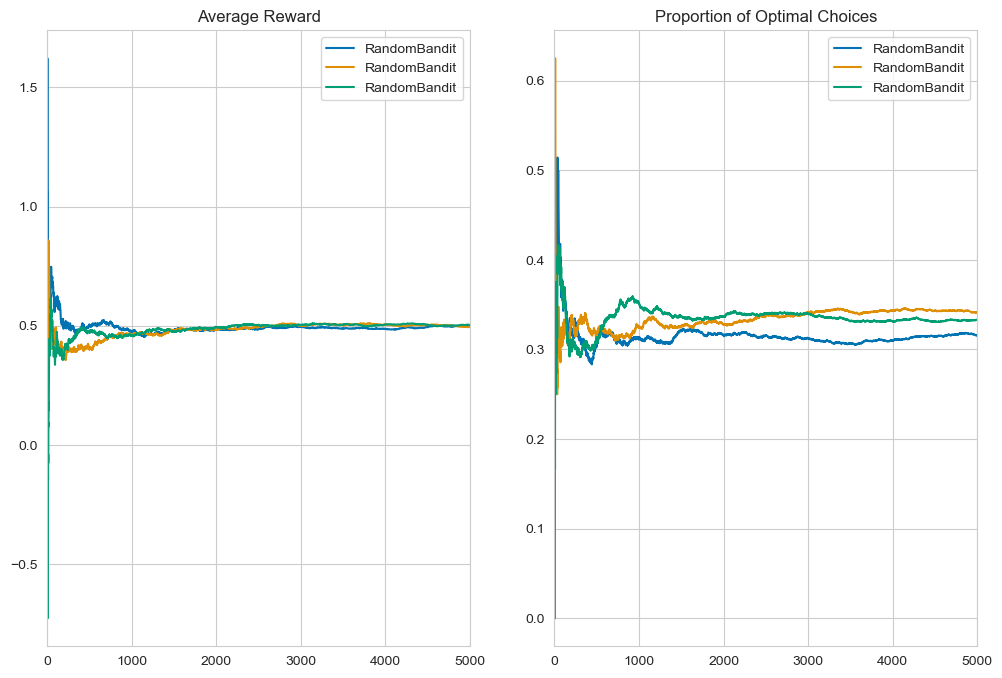

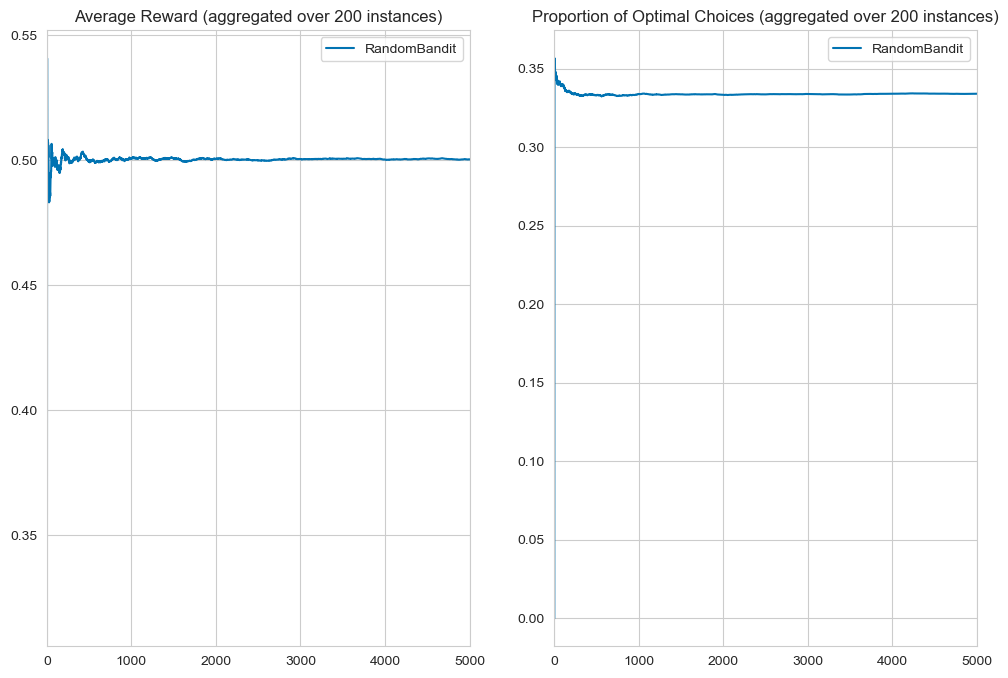

In [9]:
conduct_experiment(
    bandit_settings=[BanditSettings(RandomBandit)],
    num_bandits_per_type=200,
    num_steps=5000,
    distribution_means=[0.3, 0.55, 0.65],
)

## Greedy Bandit

Now, let's implement the `GreedyBandit` class, which will estimate the "value" of each arm based on its mean reward

In [10]:
class GreedyBandit(BaseBandit):
    """
    Represents a multi-armed bandit strategy that selects the arm with the
    highest estimated reward value.

    The GreedyBandit strategy chooses the arm based on the past rewards it
    has received. Specifically, it divides the total rewards for each arm
    by the number of times that arm has been chosen, and then selects the
    arm with the highest average reward.
    """

    def next_arm_idx(self):
        curr_m = self.rewards / self.arms_counter
        return np.argmax(curr_m)

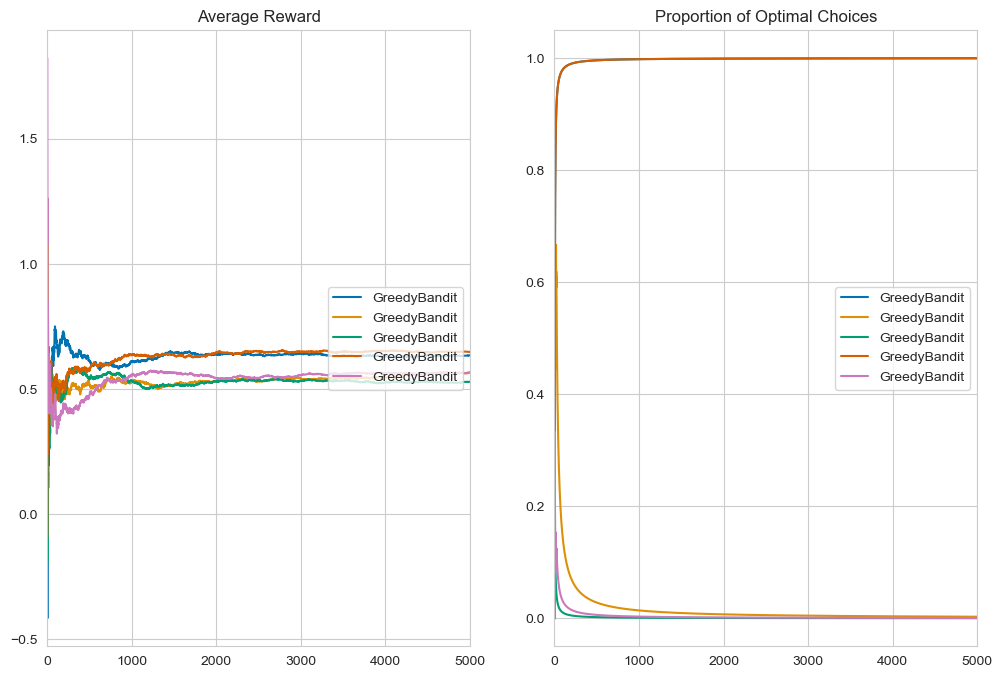

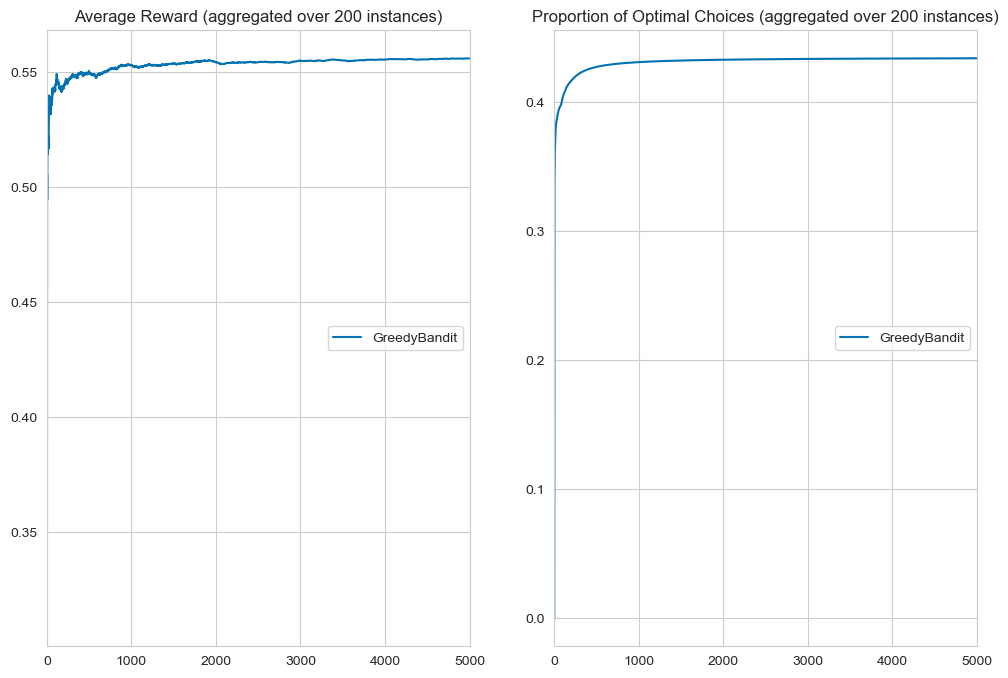

In [11]:
conduct_experiment(
    bandit_settings=[BanditSettings(GreedyBandit)],
    num_bandits_per_type=200,
    num_steps=5000,
    distribution_means=[0.3, 0.55, 0.65],
    num_bandits_for_sanity_check=5,
    loc="center right",
)

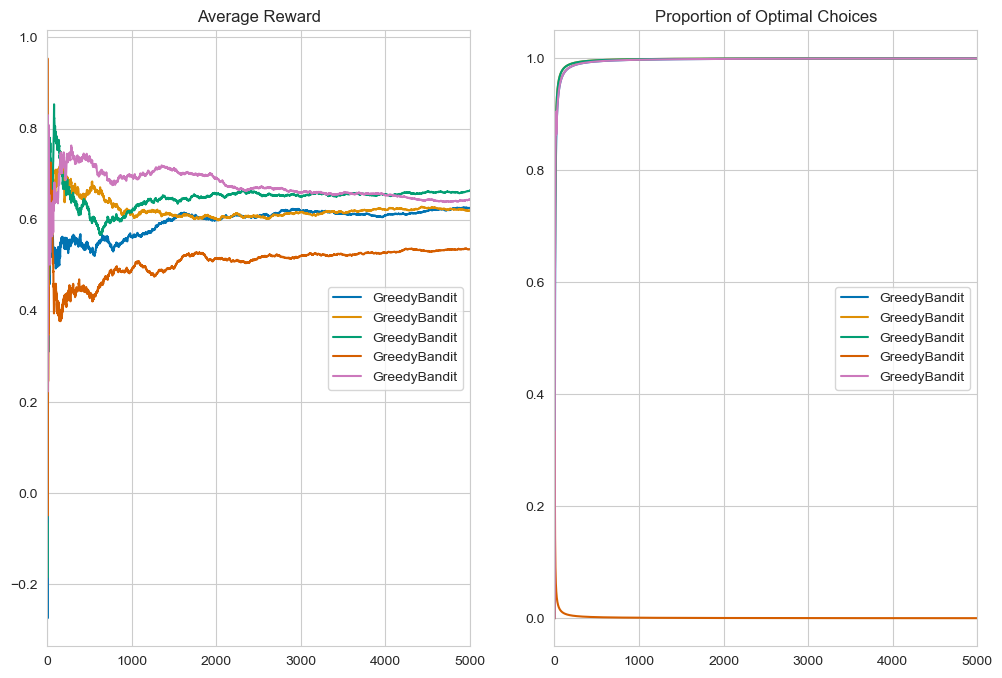

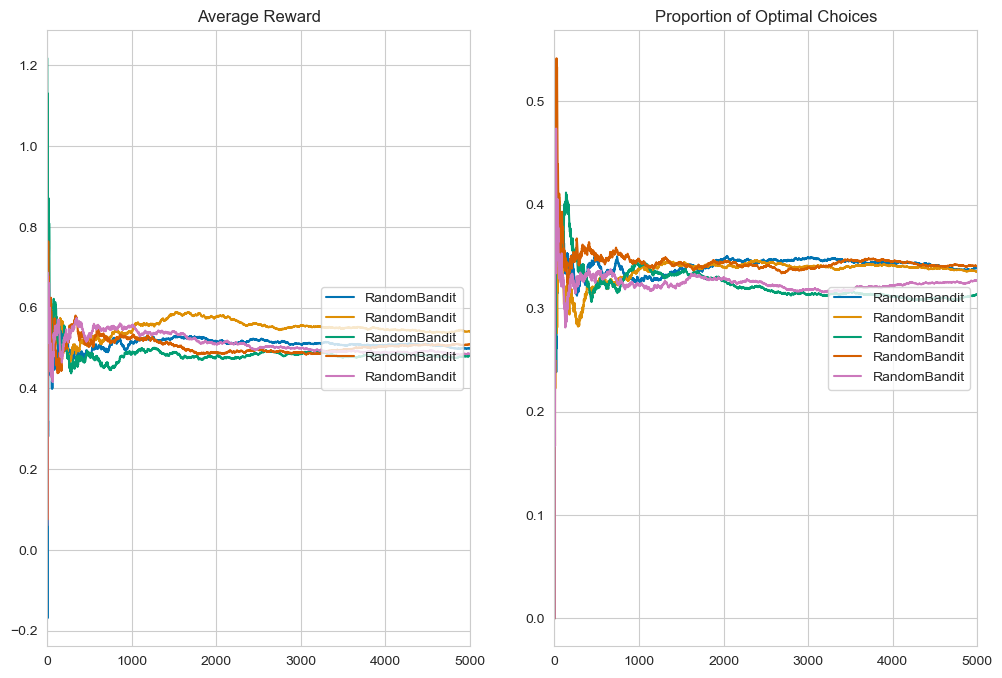

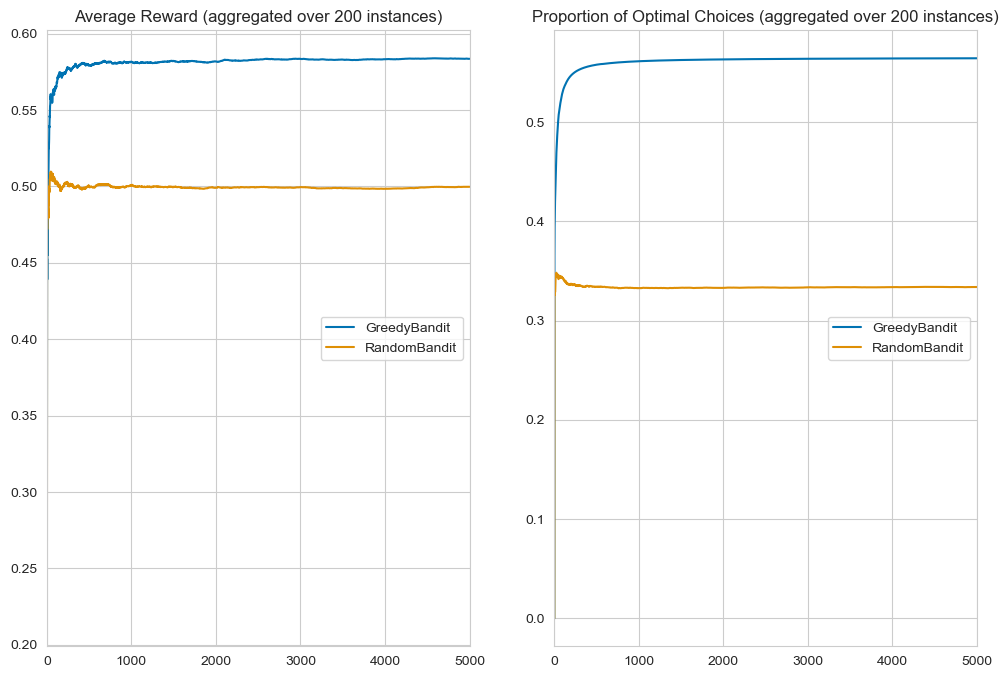

In [12]:
conduct_experiment(
    bandit_settings=[BanditSettings(GreedyBandit), BanditSettings(RandomBandit)],
    num_bandits_per_type=200,
    num_steps=5000,
    distribution_means=[0.3, 0.55, 0.65],
    num_bandits_for_sanity_check=5,
    loc="center right",
)

Re-execute the above cells several times and take note of the results.

**What patterns emerge from your observations? Can you provide a mathematical rationale for the differences between the RandomBandit and GreedyBandit approaches?**

## $\varepsilon$-greedy

The `EpsGreedyBandit` introduces exploration into our strategy: with a small probability $\varepsilon$ we will select an arm at random, and in all other cases, we will choose the greedy arm

In [13]:
class EpsGreedyBandit(BaseBandit):
    """
    Represents the ε-greedy bandit strategy. This strategy primarily exploits the
    best-performing arm but occasionally explores other arms based on a probability ε.

    Attributes
    ----------
    eps : float
        The exploration probability. A value between 0 (no exploration, purely greedy)
        and 1 (pure exploration, random choice of arms).
    """

    def __init__(self, num_arms: int, label: str = None, eps: float = 1.0):
        """
        Initialize the EpsGreedyBandit with a given number of arms and exploration probability ε.

        Parameters
        ----------
        num_arms : int
            The total number of arms in the bandit.
        label : str, optional
            A label for the bandit strategy.
        eps : float, optional
            The exploration probability. Default is 1.0 (pure exploration).
        """
        super().__init__(
            num_arms, label or f"$\\epsilon$-greedy strategy, $\\epsilon={eps}$"
        )
        if eps > 1.0 or eps < 0.0:
            raise ValueError("Eps value must be between 0 and 1")
        self.eps = eps

    def next_arm_idx(self):
        """
        Choose the next arm to pull based on the ε-greedy strategy.

        Returns
        -------
        int
            The index of the arm to pull next.
        """
        epsilon = np.random.choice(a=[0, 1], p=[self.eps, 1 - self.eps])
        if epsilon == 0:
            return np.random.choice(self.num_arms)
        else:
            curr_m = self.rewards / self.arms_counter
            return np.argmax(curr_m)

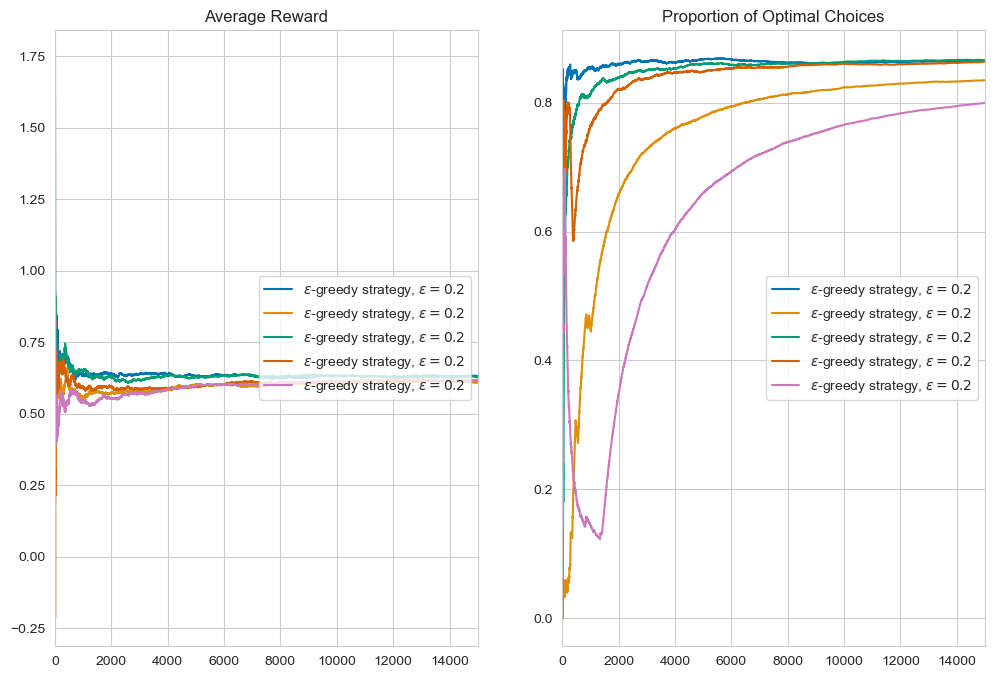

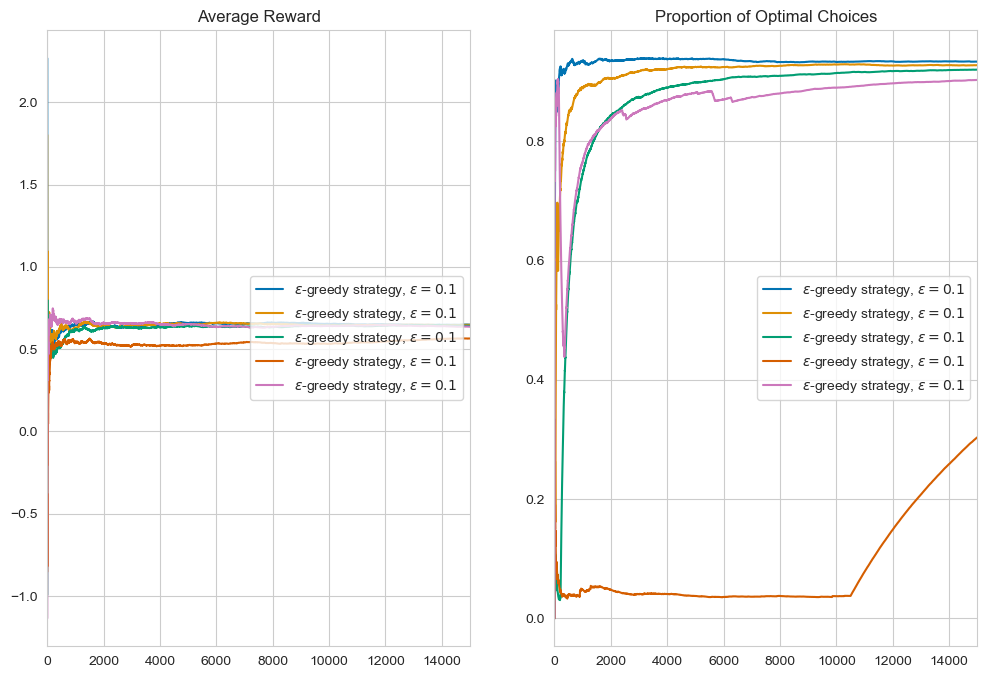

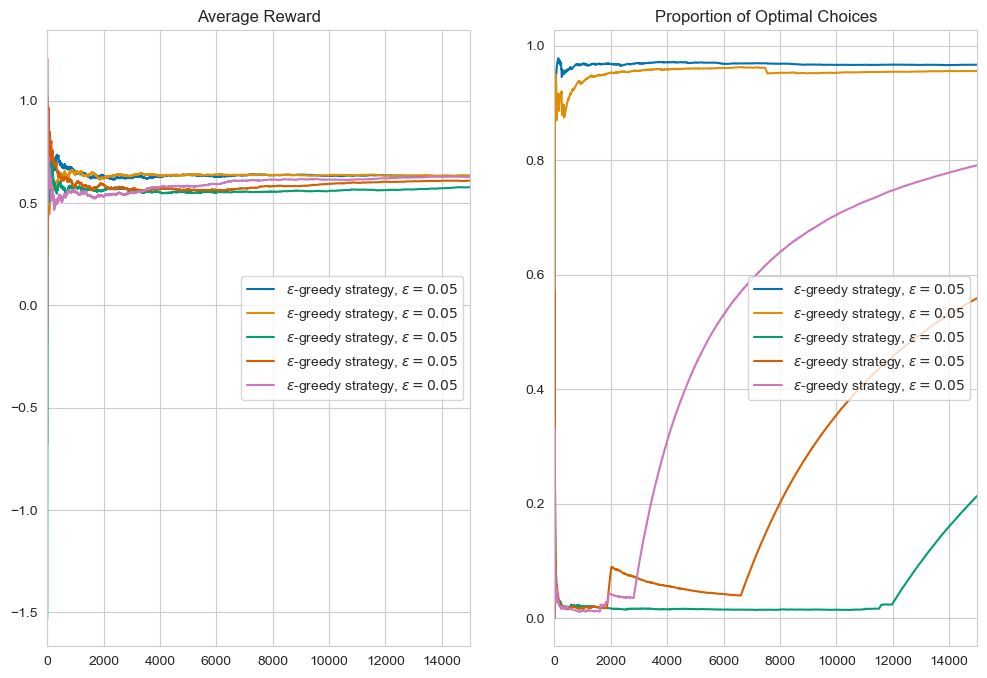

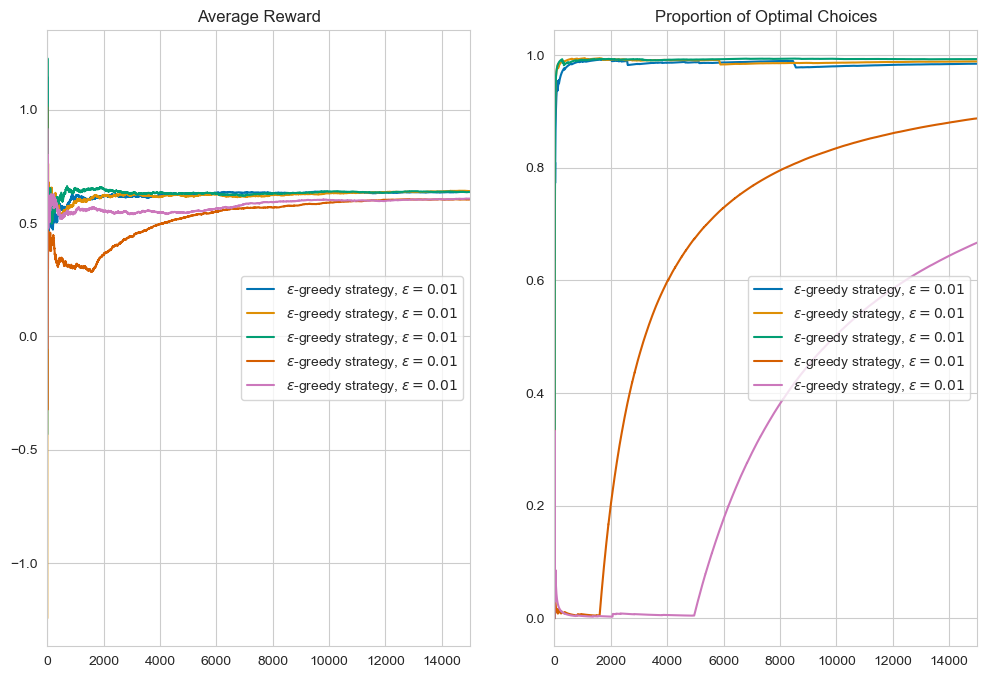

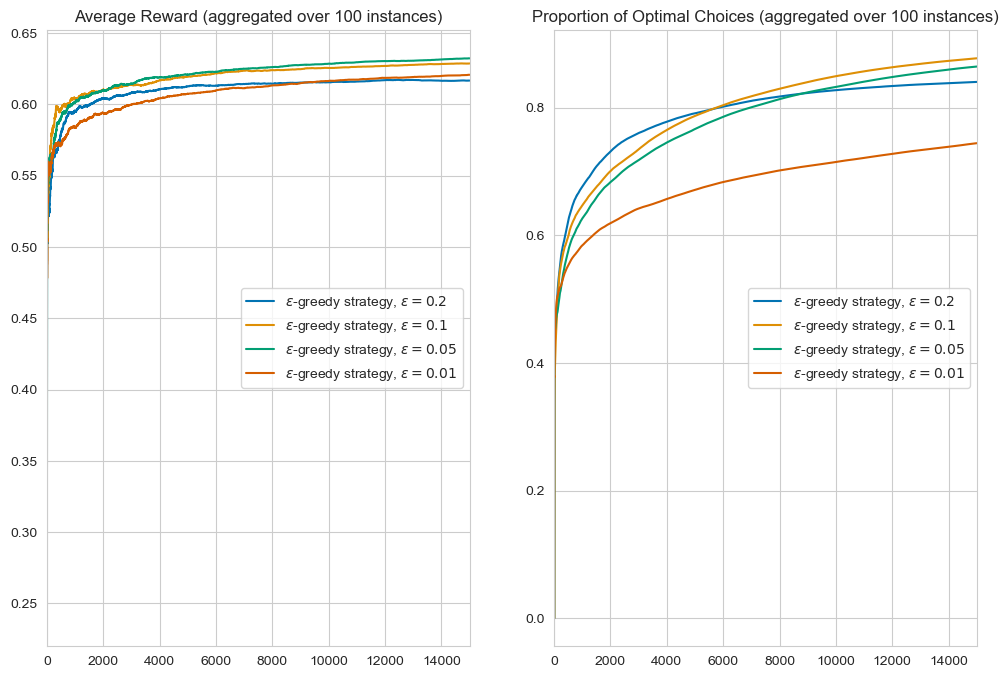

In [14]:
conduct_experiment(
    bandit_settings=[
        BanditSettings(EpsGreedyBandit, params={"eps": eps})
        for eps in (0.2, 0.1, 0.05, 0.01)
    ],
    num_bandits_per_type=100,
    num_steps=15_000,
    distribution_means=[0.3, 0.55, 0.65],
    num_bandits_for_sanity_check=5,
    loc="center right",
)

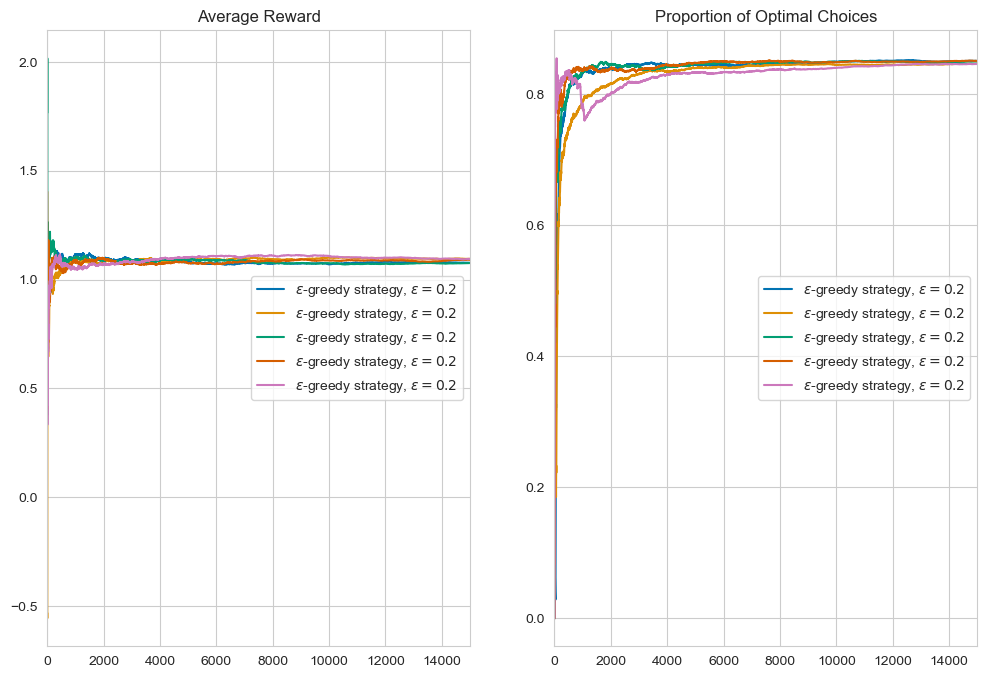

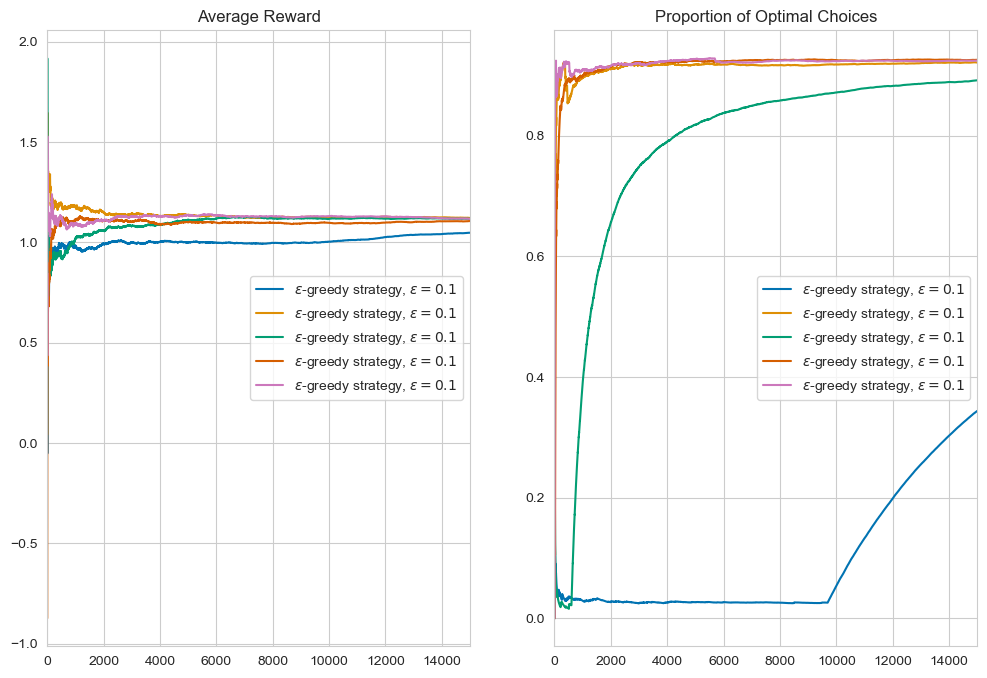

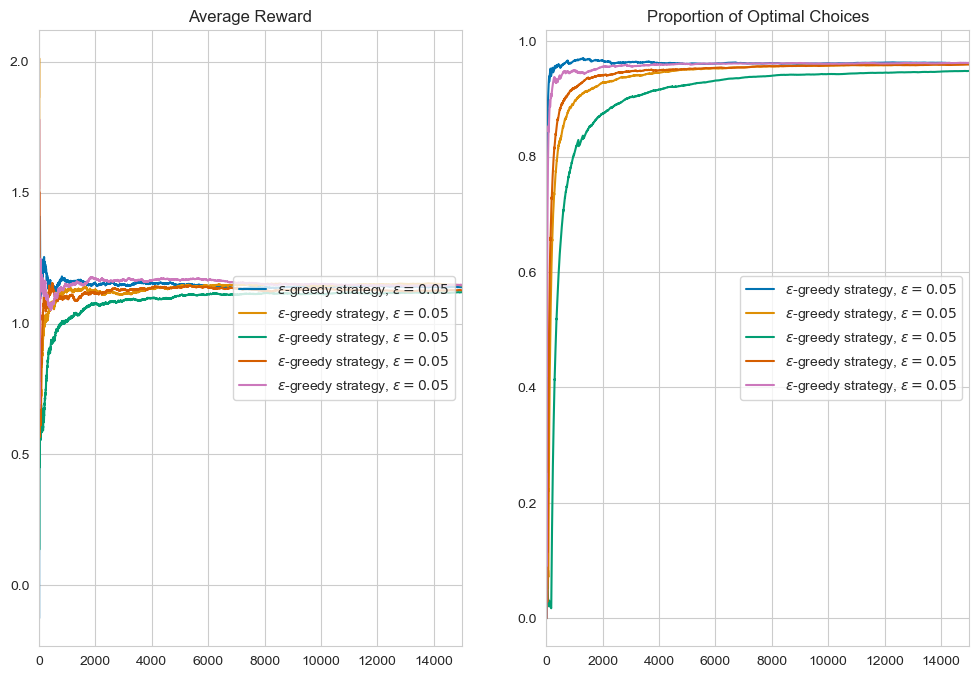

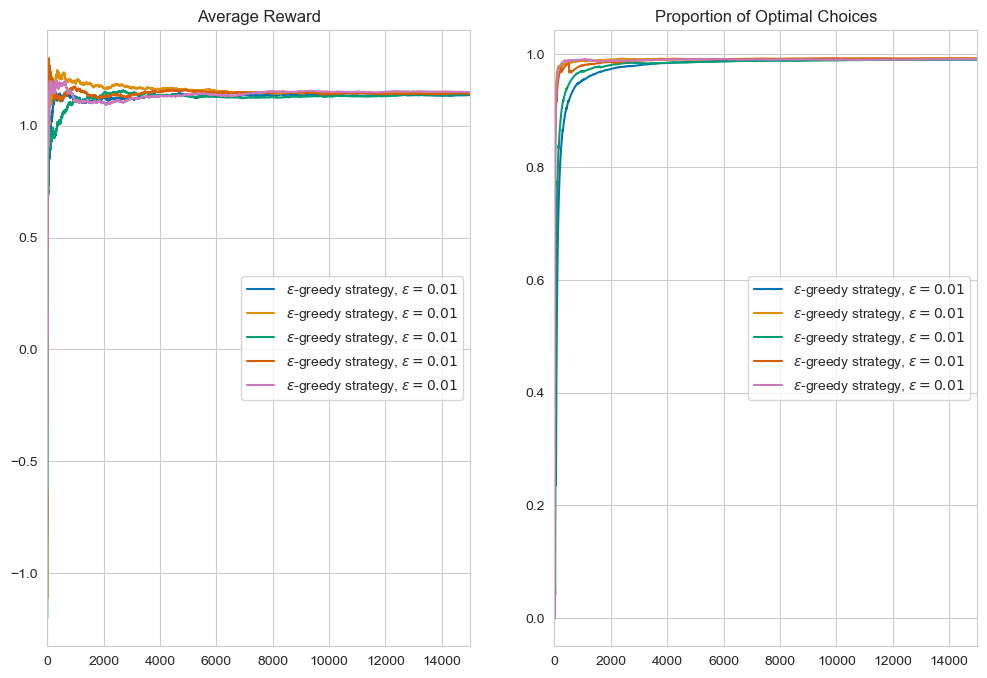

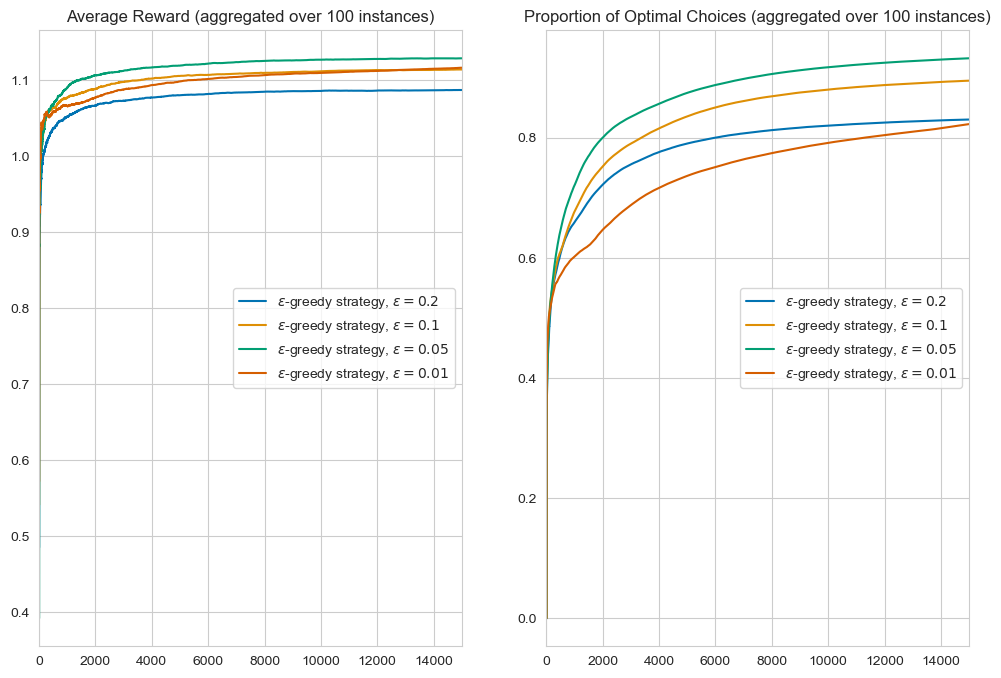

In [15]:
conduct_experiment(
    bandit_settings=[
        BanditSettings(EpsGreedyBandit, params={"eps": eps})
        for eps in (0.2, 0.1, 0.05, 0.01)
    ],
    num_bandits_per_type=100,
    num_steps=15_000,
    distribution_means=[0.5, 0.75, 1.0, 1.15],
    num_bandits_for_sanity_check=5,
    loc="center right",
)

Let's compare different `EpsGreedyBandit`, `GreedyBandit` and `RandomBandit` with each other.

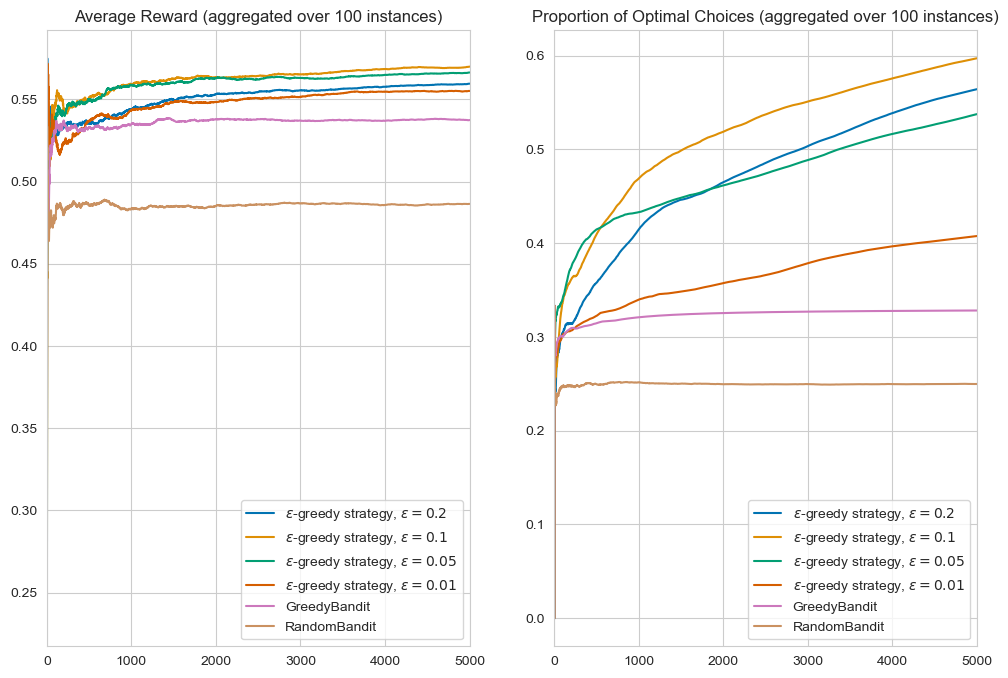

In [16]:
settings = []
for eps in (0.2, 0.1, 0.05, 0.01):
    settings.append(BanditSettings(EpsGreedyBandit, params={"eps": eps}))
settings.append(BanditSettings(GreedyBandit))
settings.append(BanditSettings(RandomBandit))

conduct_experiment(
    bandit_settings=settings,
    num_bandits_per_type=100,
    num_steps=5000,
    distribution_means=[0.3, 0.5, 0.6, 0.55],
    num_bandits_for_sanity_check=0,
    loc="lower right",
)

**Answer the following questions**

Upon analyzing the simulation results:

- Which strategy seems to have the quickest convergence towards the optimal arm? Why do you think this is the case?
- How does the ε value in the `EpsGreedyBandit` affect the bandit's performance? Between ε=0.1 and ε=0.01, which seems to strike a better balance between exploration and exploitation over time?
- Based on your observations, in a real-world scenario where the true probabilities are unknown, which strategy would you recommend for initial trials? And which one for long-term deployment?


## UCB1

> Exploration is needed because there is always uncertainty about the accuracy of the action-value estimates. The greedy actions are those that look best at present, but some of the other actions may actually be better. $\varepsilon$-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates. One effective way of doing this is to select actions according to $A_t = \arg\max_t \left[ Q_t + c \cdot \sqrt{\frac{\ln{t}}{N_t(a)}} \right]$ where $Q_t$ is the estimation of the "value" of the arm at time $t$ - the empirical mean based on the prior rewards, $N_t$ is the counter for the arm at time $t$ and $c$ is some constant.

For more, see [Sutton, Barto](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf) (page 36) and [Auer, P., Cesa-Bianchi, N. & Fischer, P. Finite-time Analysis of the Multiarmed Bandit Problem. Machine Learning 47, 235–256 (2002)](https://link.springer.com/article/10.1023/A:1013689704352)

In [17]:
class UCB1Bandit(BaseBandit):
    """
    Implements the Upper Confidence Bound (UCB1) multi-armed bandit strategy.

    The UCB1 algorithm is designed to balance exploration and exploitation by
    selecting arms that have the highest upper confidence bounds. Specifically,
    it selects the arm that maximizes the sum of its empirical mean reward and
    an uncertainty term that decreases as the arm is pulled more often.

    Attributes
    ----------
    c : float
        The exploration parameter which determines the degree of exploration
        versus exploitation. A higher value results in more exploration.
    """

    def __init__(self, num_arms: int, label: str = None, c: float = np.sqrt(2)):
        super().__init__(num_arms, label or f"UCB1 ({c:.4f})")
        self.c = c

    def next_arm_idx(self):
        return np.argmax(
            np.true_divide(self.rewards, self.arms_counter)
            + self.c * np.sqrt(np.array(np.log(len(self.hist)) / self.arms_counter))
        )

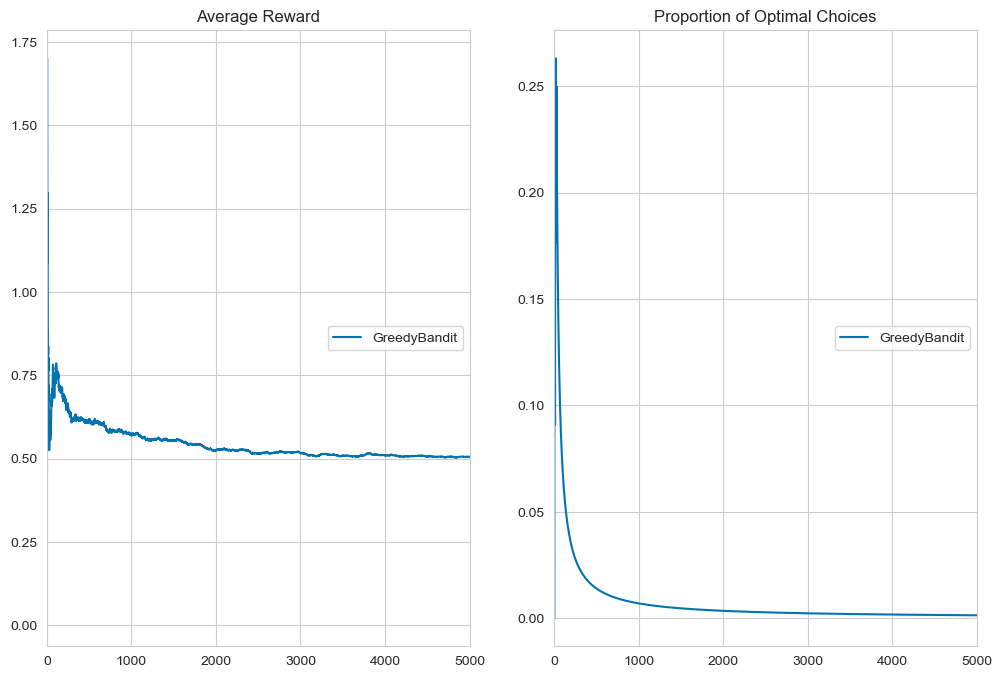

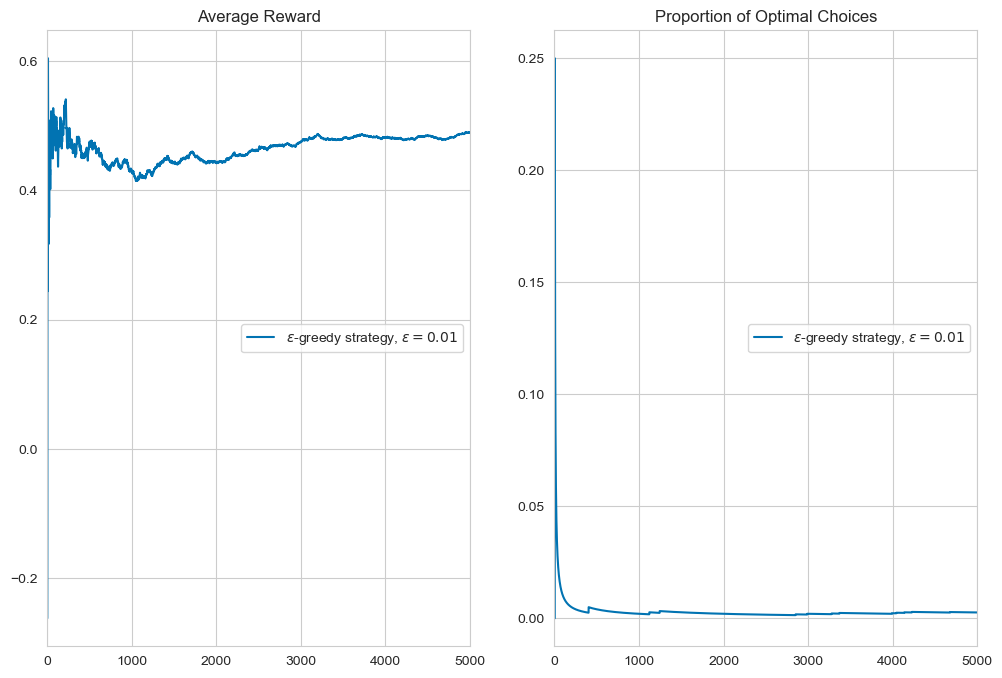

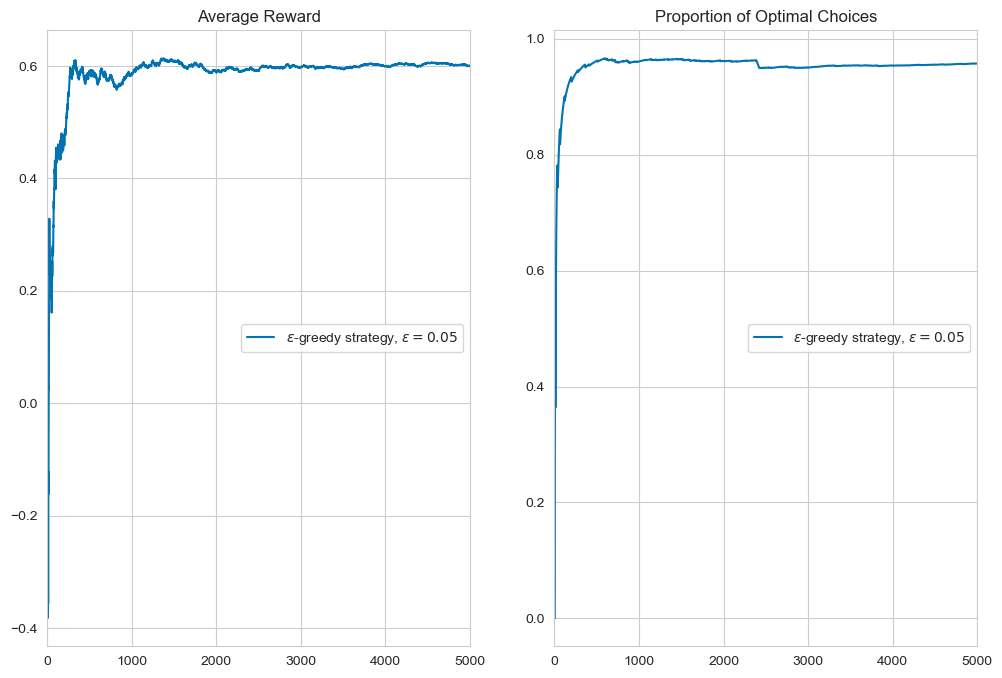

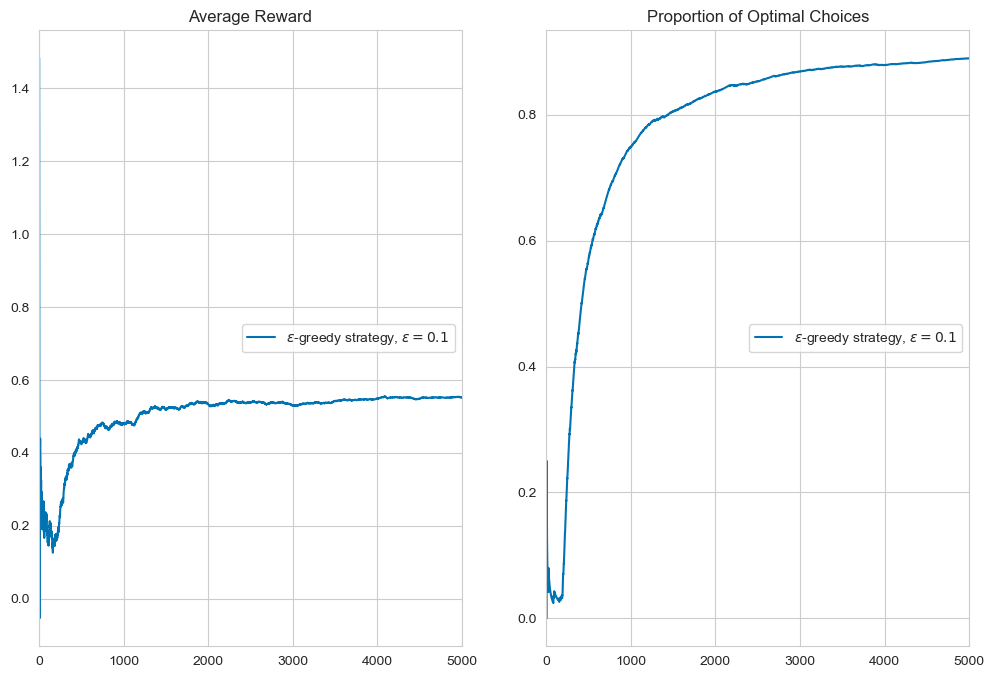

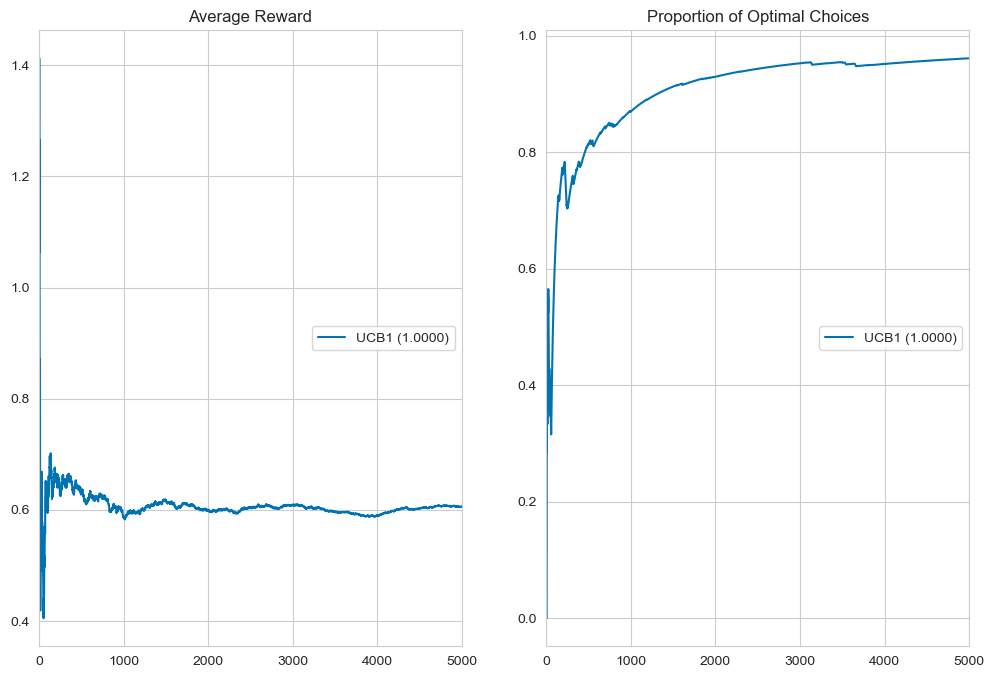

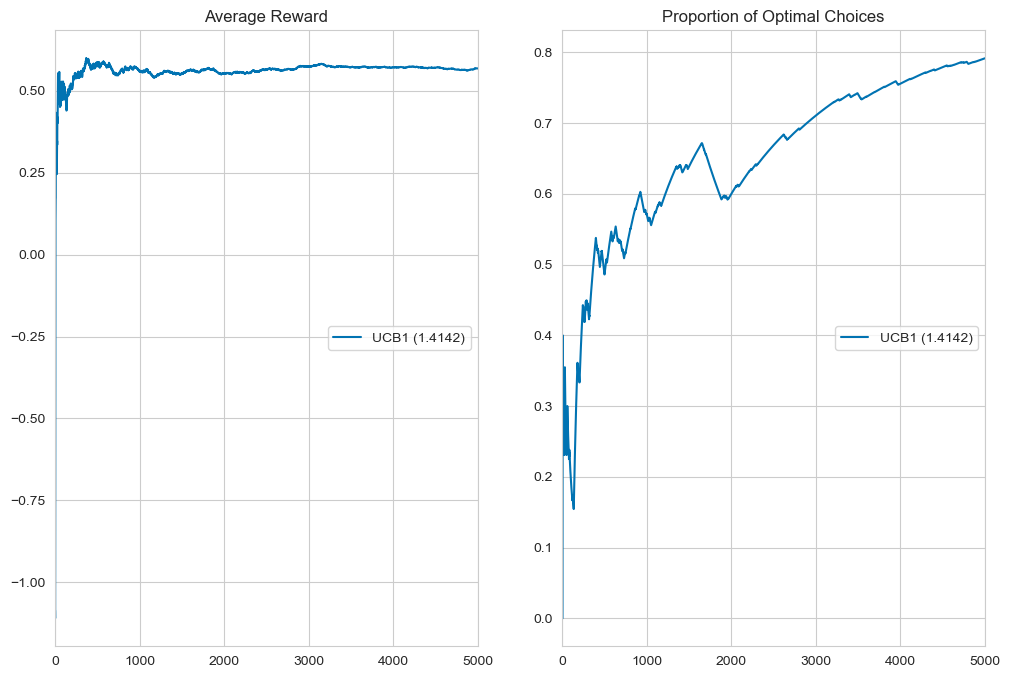

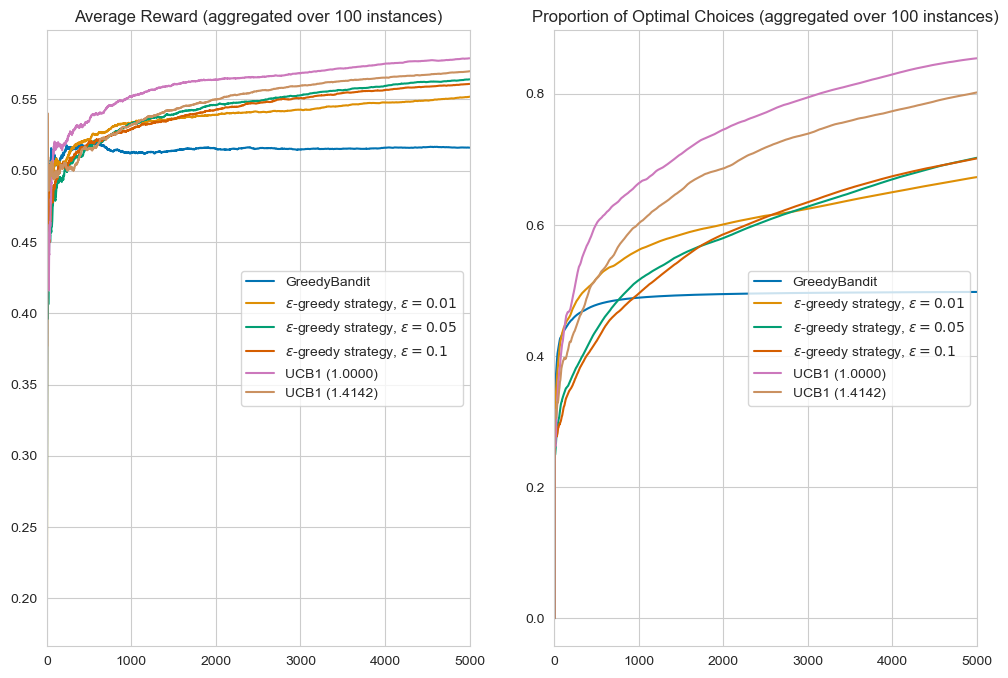

In [18]:
settings = [
    BanditSettings(GreedyBandit),
    BanditSettings(EpsGreedyBandit, params={"eps": 0.01}),
    BanditSettings(EpsGreedyBandit, params={"eps": 0.05}),
    BanditSettings(EpsGreedyBandit, params={"eps": 0.1}),
    BanditSettings(UCB1Bandit, params={"c": 1.0}),
    BanditSettings(UCB1Bandit, params={"c": np.sqrt(2)}),
]

conduct_experiment(
    bandit_settings=settings,
    num_bandits_per_type=100,
    num_steps=5000,
    distribution_means=[0.3, 0.4, 0.5, 0.6],
    num_bandits_for_sanity_check=1,
    loc="center right",
)

After observing the performance of the various bandit strategies, try running the `UCB1Bandit` again but with a different value for the constant `c`. 

**How does adjusting this constant influence the bandit's performance and its exploration-exploitation balance?**

## Thompson sampling

**Thompson Sampling**, also known as posterior sampling, is a probability-based algorithm used for solving the multi-armed bandit problem.

The fundamental idea behind Thompson Sampling is to maintain a probability distribution over the expected reward of each arm and, at each step, pull the arm that has the highest potential reward according to a sample from these distributions.

Here's a step-by-step breakdown:

- **Initialization**: For each arm, we start with a prior distribution over its expected reward. This is typically chosen to be a Beta distribution, **due to its conjugate property with the Bernoulli distribution (which describes the reward process of each arm).**
- **Sampling**: For each arm, draw a sample from its current distribution. This gives us a potential reward for each arm.
- **Selection**: Pull the arm that has the highest sampled reward.
- **Update**: After observing the reward of the pulled arm, update its distribution. The distribution moves closer to the true reward of the arm with each pull, refining our knowledge over time.

The beauty of Thompson Sampling lies in its balance between exploration and exploitation. Instead of just exploiting the arm with the best observed reward or exploring randomly, it probabilistically pulls an arm based on our current knowledge, allowing for both exploration and exploitation.

```
Initialize:
    For i = 1 to n_arms:
        trials[i] ← 0                 // Number of times arm i has been pulled
        rewards[i] ← 0                // Total reward received from arm i
        ALPHA[i] ← 1                  // Alpha parameter for arm i's Beta distribution
        BETA[i] ← 1                   // Beta parameter for arm i's Beta distribution

For step = 1 to num_steps:
    For i = 1 to n_arms:
        theta[i] ← Sample from Beta(ALPHA[i], BETA[i])

    chosen_arm ← argmax_i(theta[i])

    r ← Pull(chosen_arm)             // Pull the chosen arm and observe reward r

    Update:
        trials[chosen_arm] ← trials[chosen_arm] + 1
        rewards[chosen_arm] ← rewards[chosen_arm] + r

        // Assuming a binary reward (0 or 1):
        If r = 1:
            ALPHA[chosen_arm] ← ALPHA[chosen_arm] + 1
        Else:
            BETA[chosen_arm] ← BETA[chosen_arm] + 1

End For
```

In [19]:
class ThompsonBandit(BaseBandit):
    """
    Represents a bandit using the Thompson Sampling strategy.
    **Uses Beta-distibution for prioirs, assuming that the rewards are distributed according to the Bernoulli distribution.**
    """

    def __init__(self, num_arms: int, label: str = None):
        super().__init__(num_arms, label)
        # Initialize alpha and beta for each arm's Beta distribution (start with 1,1 which is a uniform distribution)
        self.alpha = np.ones(self.num_arms)
        self.beta = np.ones(self.num_arms)

    def next_arm_idx(self):
        """
        Determine the next arm to pull using Thompson Sampling.

        Returns
        -------
        int
            Index of the chosen arm.
        """
        theta = np.empty(self.num_arms)
        for i in range(self.num_arms):
            theta[i] = np.random.beta(self.alpha[i], self.beta[i])
        return np.argmax(theta)
    
    def add_result(self, arm_idx: int, reward: float):
        """
        Record the result of pulling an arm and update Beta distribution parameters.

        Parameters
        ----------
        arm_idx : int
            Index of the arm that was pulled.

        reward : float
            Reward received from pulling the arm.
        """
        super().add_result(arm_idx, reward)
        
        if reward > 0:
            self.alpha[arm_idx] += 1
        else:
            self.beta[arm_idx] += 1        


    def plot_distributions(self, ax, step):
        """
        Plot the probability distributions for each arm based on the alpha and beta parameters at timestamp `step`.
        Use `self.hist` to obtain the state of `self.alpha` and `self.beta` at step `step`.

        Parameters:
        - ax: The axis on which to plot the distributions.
        - step: The step in the simulation.
        """
        xs = np.linspace(0.001, 0.999, 100)
        alpha, beta = np.ones(self.num_arms), np.ones(self.num_arms)
        rewards, arms_counter = np.zeros(self.num_arms), np.zeros(
            self.num_arms, dtype=int
        )

        for step_id in range(step):
            history_record = self.hist[step_id]
            rewards[history_record.arm_idx] += history_record.reward
            arms_counter[history_record.arm_idx] += 1

            if history_record.reward > 0:
                alpha[history_record.arm_idx] += history_record.reward
            else:
                beta[history_record.arm_idx] += 1 - history_record.reward

        for arm_idx in range(self.num_arms):
            prior = st.beta(a=alpha[arm_idx], b=beta[arm_idx])
            y = prior.pdf(xs)
            ax.plot(
                xs,
                y,
                label=f"Arm {arm_idx + 1}: {prior.mean():.4f} {int(rewards[arm_idx])}/{int(arms_counter[arm_idx])}",
            )
            ax.fill_between(xs, y, 0, alpha=0.2)

        ax.set_xlim([0, 1])
        ax.set_ylim(bottom=0)
        ax.legend(loc="upper left")
        ax.set_title(f"Distribution on Step {step}")

Let's see how the estimation of the current params changes as we observe more results from the bandit.

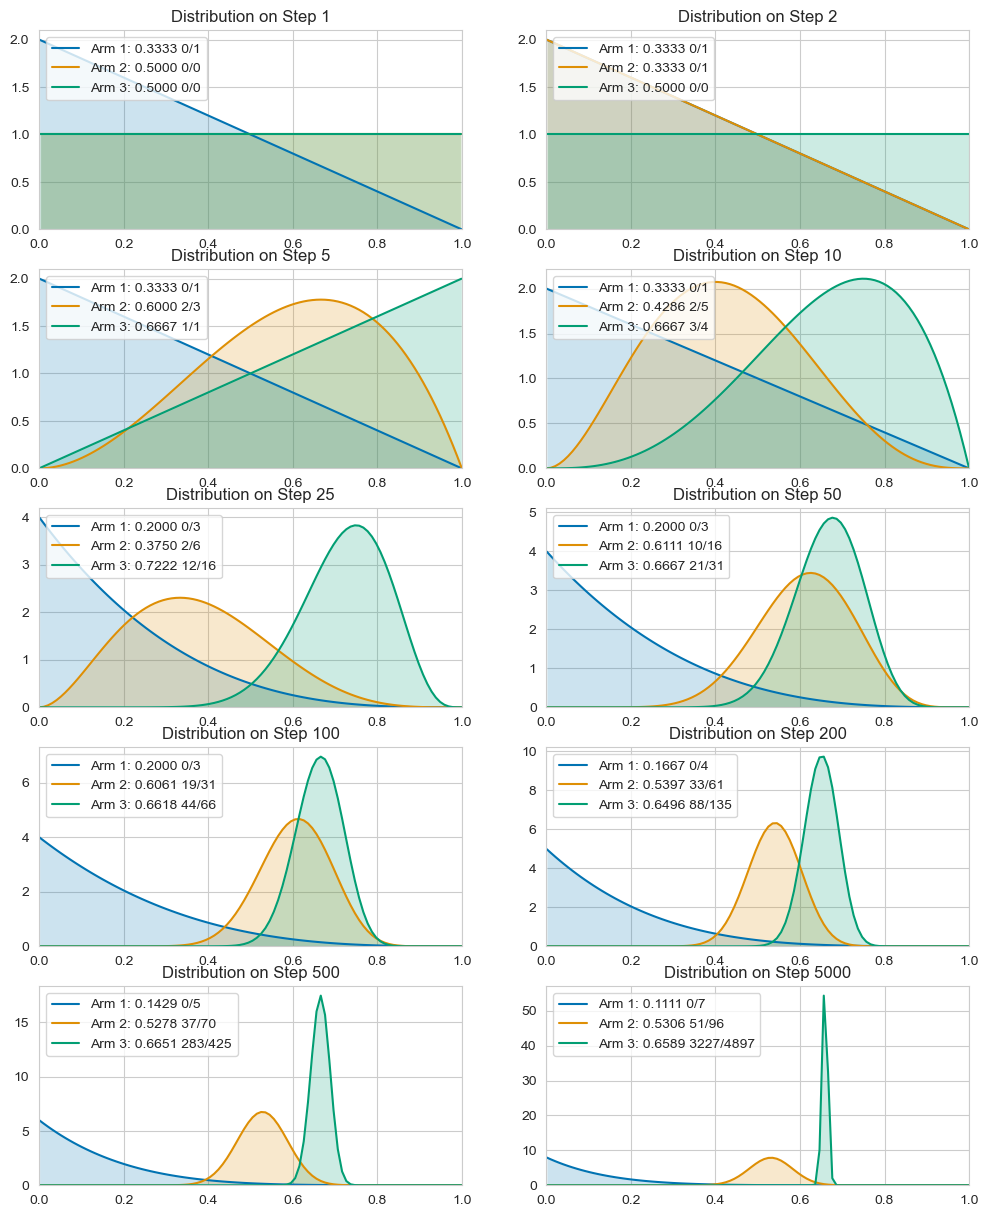

In [20]:
fig, axs = plt.subplots(5, 2, figsize=(12, 15))
axs = axs.flat

thompson_bandit = ThompsonBandit(3)
run_bandits(
    [thompson_bandit],
    np.array([0.3, 0.55, 0.65]),
    pull=pull_np,
    n_steps=5000,
)

for step in (1, 2, 5, 10, 25, 50, 100, 200, 500, 5000):
    thompson_bandit.plot_distributions(next(axs), step)

plt.show()

As can be seen, our estimates get better over time and, by the Step #5000, the estimation of parameters is quite close to the actual values.

Now let's compare UCB1 vs. Thompson Sampling assuming are rewards follow the Bernoulli distribution.

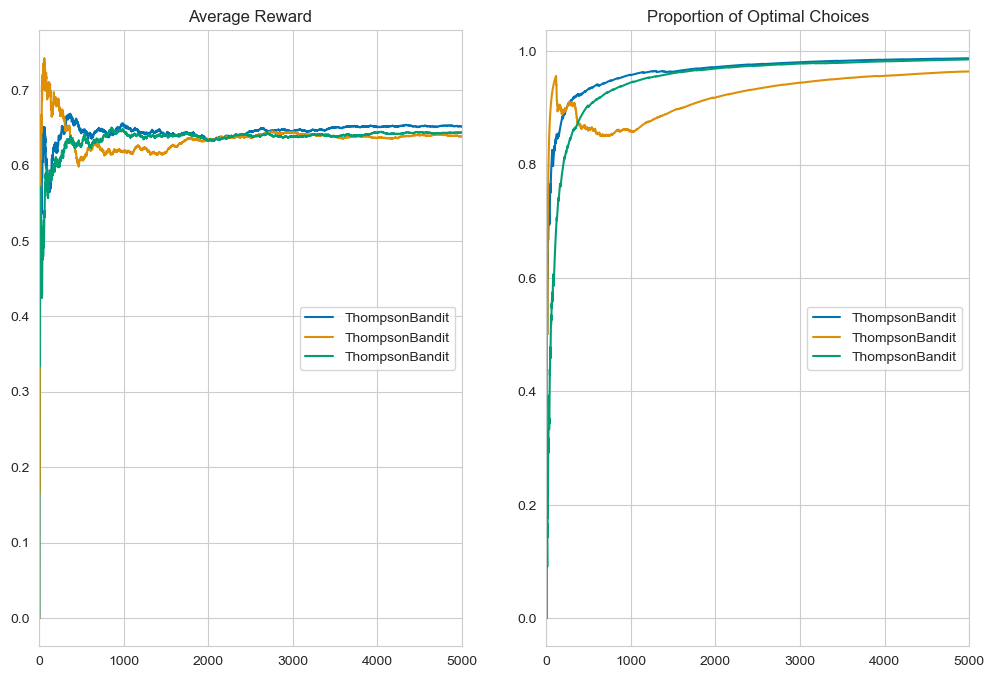

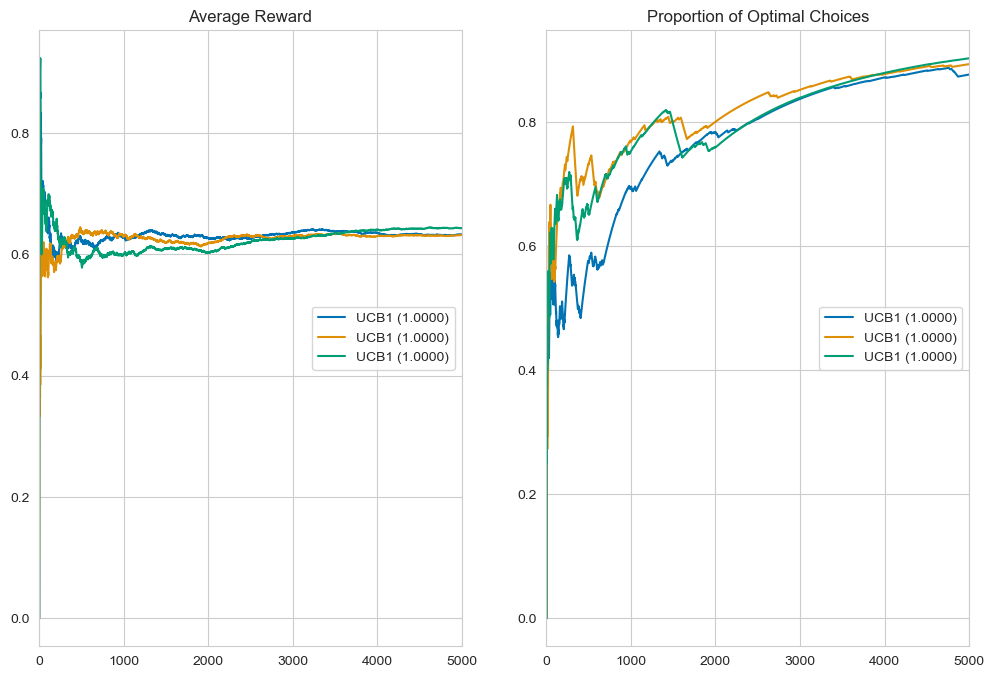

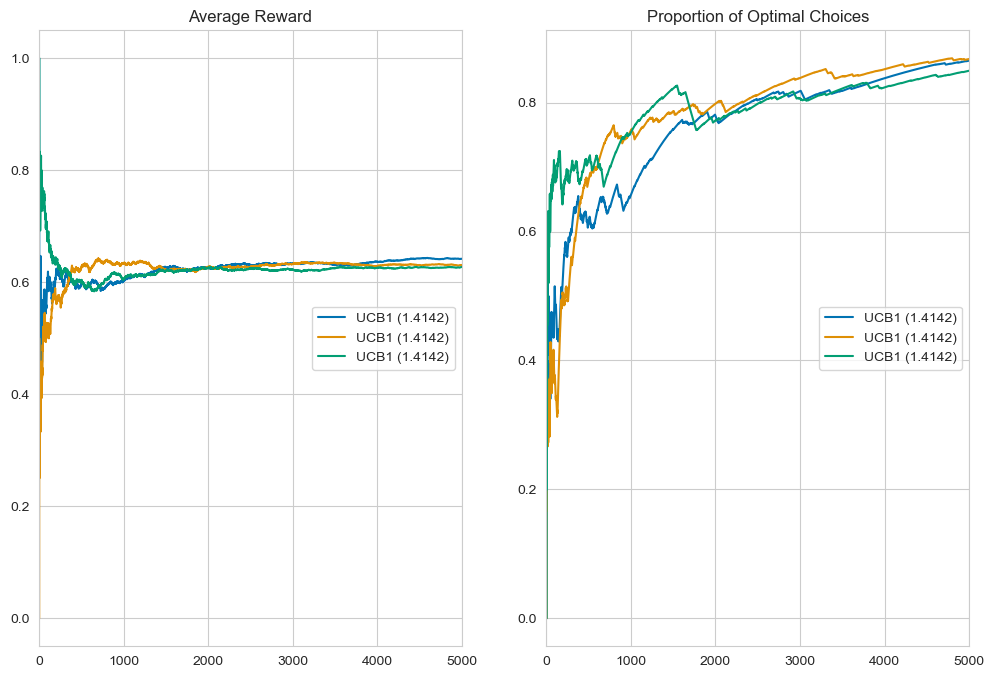

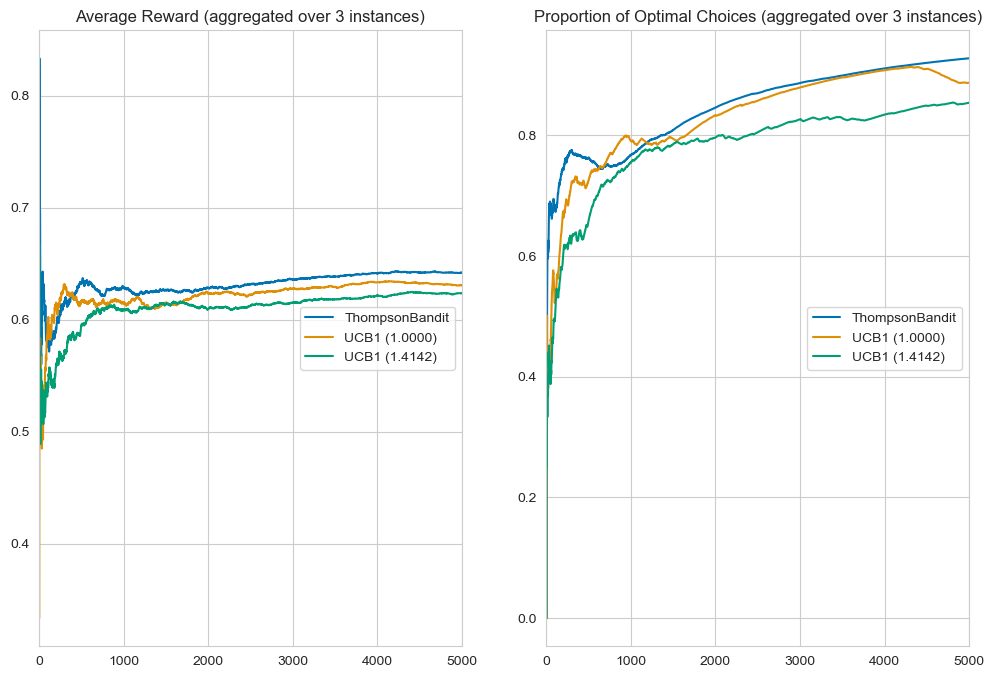

In [21]:
settings = [
    BanditSettings(ThompsonBandit),
    BanditSettings(UCB1Bandit, params={"c": 1.0}),
    BanditSettings(UCB1Bandit, params={"c": np.sqrt(2)}),
]

conduct_experiment(
    bandit_settings=settings,
    num_bandits_per_type=3,
    num_steps=5000,
    distribution_means=[0.3, 0.55, 0.65],
    num_bandits_for_sanity_check=3,
    is_gauss=False,
    loc="center right",
)

The Thompson bandit handles this case a little bit better than UCB1.